<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Cross_validation_for_regression_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...please load your drive...")
def time_fmt(x:float=124.2738)->float:
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"<---testing--->time elapse: {time_fmt()}")

Mounted at /content/drive/
You are on colab with tensorflow version: 2.4.1
<---testing--->time elapse: 0: 002: 04.00


In [ ]:
import tensorflow as tf
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
%matplotlib inline
pd.set_option('max_rows', 6)
pd.set_option('max_columns', 0)
plt.style.use('fivethirtyeight')



In [ ]:
#Get the data from the url

In [ ]:
data = pd.read_csv("https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv", na_values = ['NA', '?','NAN'])

In [ ]:
display(data)

,id,job,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,1,vv,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,2,kd,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,3,pe,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,1998,kl,d,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703,f
1998,1999,qp,c,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803,c
1999,2000,pe,c,61467.0,16.891667,0,4.312097,8,9.405648,48,0.925197,0.539370,0.451973,c


In [ ]:
data.isna().value_counts()

id     job    area   income  aspect  subscriptions  dist_healthy  save_rate  dist_unhealthy  age    pop_dense  retail_dense  crime  product
False  False  False  False   False   False          False         False      False           False  False      False         False  False      1941
                     True    False   False          False         False      False           False  False      False         False  False        59
dtype: int64

In [ ]:
#Replace missing income entries with the median income:

In [ ]:
data['income'] = data['income'].fillna(data['income'].median())

In [ ]:
#We want to predict income based on other factors: We can plot the median income wrt other factors to see the general trend:

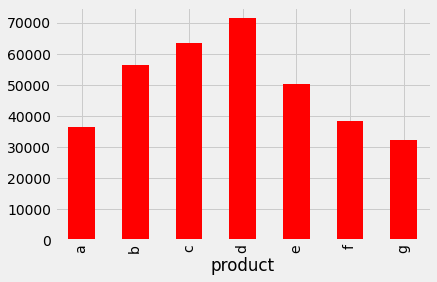

In [ ]:
data.groupby('product').income.median().plot(kind = 'bar', color = 'red')

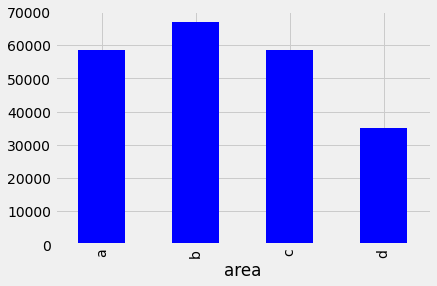

In [ ]:
data.groupby('area').income.median().plot(kind = 'bar', color = 'blue')

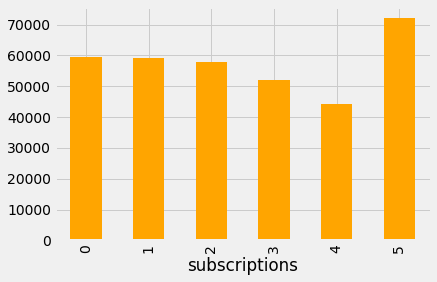

In [ ]:
data.groupby('subscriptions').income.median().plot(kind = 'bar', color = 'orange')

[Text(0, 0.5, 'income'), Text(0.5, 0, 'saving rate')]

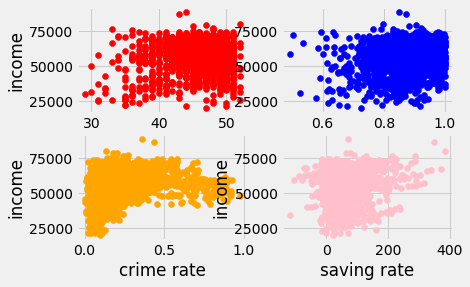

In [ ]:
fig, axes = plt.subplots(2,2)
axes[0,0].scatter(data['age'], data['income'],color = 'red')
#axes[0,0].set_title('age v income')
axes[0,0].set(xlabel = 'age', ylabel = 'income')
axes[0,1].scatter(data['pop_dense'], data['income'], color = 'blue')
#axes[0,1].set_title('population density v income')
axes[0,1].set(xlabel = 'population density')
axes[1,0].scatter(data['crime'], data['income'],color = 'orange')
#axes[1,0].set_title('crime rate v income')
axes[1,0].set(xlabel = 'crime rate', ylabel = 'income')
axes[1,1].scatter(data['save_rate'], data['income'], color = 'pink')
#axes[1,1].set_title('saving rate v income')
axes[1,1].set(xlabel = 'saving rate', ylabel = 'income')


In [ ]:
#Looking for the scatter plots above we can see some trends on income based on some other factors
#with some few extremes

In [ ]:
#Data preparation for regression neural net

In [ ]:
data.drop('id', axis = 1, inplace = True)

In [ ]:
display(data)

,job,area,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,vv,c,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,kd,c,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,pe,c,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,kl,d,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703,f
1998,qp,c,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803,c
1999,pe,c,61467.0,16.891667,0,4.312097,8,9.405648,48,0.925197,0.539370,0.451973,c


In [ ]:
job_cat = pd.get_dummies(data['job'], prefix = 'job')
area_cat = pd.get_dummies(data['area'], prefix = 'area')
product_cat = pd.get_dummies(data['product'], prefix = 'product')


In [ ]:
target = zscore(data['income'])

In [ ]:
data.drop(['job','area','product'], axis = 1, inplace = True)

In [ ]:
#Convert continous variables into zscores:
display(data)

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime
0,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100
1,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809
2,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723
...,...,...,...,...,...,...,...,...,...,...
1997,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703
1998,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803
1999,61467.0,16.891667,0,4.312097,8,9.405648,48,0.925197,0.539370,0.451973


In [ ]:
cols = data.columns
for col in cols:
  data[col] = zscore(data[col])

In [ ]:
display(data)

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime
0,-0.607550,-0.664918,-0.208449,-0.048411,-0.215764,-0.314089,0.854321,0.079279,-0.465765,-1.120315
1,0.338053,-0.207748,0.839031,-0.266765,0.196869,-0.915161,1.394432,-0.075010,-1.445372,0.682945
2,-0.184205,1.127906,-0.208449,-0.988286,-0.714362,-0.078604,-0.495957,0.850727,1.055205,-0.373087
...,...,...,...,...,...,...,...,...,...,...
1997,-2.826971,1.513363,1.886511,-0.371196,0.884591,-1.180569,-2.656402,-1.566477,1.184101,-0.969344
1998,1.093101,-1.274478,-1.255928,-0.062651,-0.370502,-1.344498,0.044154,0.387858,0.230272,-0.864885
1999,0.447425,-0.351174,-1.255928,-0.869615,-0.679976,-0.598362,0.584265,0.593578,-0.156415,0.962774


In [ ]:
data = pd.concat([data, area_cat, job_cat, product_cat], axis = 1)

In [ ]:
display(data)

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,area_a,area_b,area_c,area_d,job_11,job_al,job_am,job_ax,job_bf,job_by,job_cv,job_de,job_dz,job_e2,job_f8,job_gj,job_gv,job_kd,job_ke,job_kl,job_kp,job_ks,job_kw,job_mm,job_nb,job_nn,job_ob,job_pe,job_po,job_pq,job_pz,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz,product_a,product_b,product_c,product_d,product_e,product_f,product_g
0,-0.607550,-0.664918,-0.208449,-0.048411,-0.215764,-0.314089,0.854321,0.079279,-0.465765,-1.120315,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0.338053,-0.207748,0.839031,-0.266765,0.196869,-0.915161,1.394432,-0.075010,-1.445372,0.682945,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-0.184205,1.127906,-0.208449,-0.988286,-0.714362,-0.078604,-0.495957,0.850727,1.055205,-0.373087,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,-2.826971,1.513363,1.886511,-0.371196,0.884591,-1.180569,-2.656402,-1.566477,1.184101,-0.969344,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1998,1.093101,-1.274478,-1.255928,-0.062651,-0.370502,-1.344498,0.044154,0.387858,0.230272,-0.864885,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1999,0.447425,-0.351174,-1.255928,-0.869615,-0.679976,-0.598362,0.584265,0.593578,-0.156415,0.962774,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
display(target)

array([-0.60754957,  0.33805295, -0.18420492, ..., -2.82697122,
        1.09310058,  0.44742528])

In [ ]:
#Cross validation:
x = data.drop('income', axis = 1).values

In [ ]:
kfolds = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [ ]:
tic = time.time()
y_oos = []
pred_oos = []
fold = 0
for train, test in kfolds.split(x):
  fold+=1
  print(f"fold number: {fold}")
  x_train = x[train]
  x_test = x[test]
  y_train = target[train]
  y_test = target[test]

  model = tf.keras.models.Sequential(name = 'reg_mlp')
  model.add(tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense1'))
  model.add(tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation = 'relu', name = 'dense2'))
  model.add(tf.keras.layers.Dense(units = 1, name = 'outputs'))
  model.compile(optimizer = 'Adam', loss = 'mean_squared_error')
  model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 2, epochs = 100)
  preds = model.predict(x_test)
  y_oos.append(y_test)
  pred_oos.append(preds)
  se_fold_score = np.sqrt(mean_squared_error(preds, y_test))
  print(f"RMSE for fold {fold} is:{se_fold_score:.4f}")

y_oos = np.concatenate(y_oos)
pred_oos = np.concatenate(pred_oos)
se_score_avg = np.sqrt(mean_squared_error(y_oos, pred_oos))
print(f"overall RMSE is {se_score_avg:.4f}")
toc = time.time()
print()
print(f"time elapse is: {time_fmt(toc - tic)}")




fold number: 1
Epoch 1/100
50/50 - 1s - loss: 0.6235 - val_loss: 0.2531
Epoch 2/100
50/50 - 0s - loss: 0.2387 - val_loss: 0.1635
Epoch 3/100
50/50 - 0s - loss: 0.1959 - val_loss: 0.1488
Epoch 4/100
50/50 - 0s - loss: 0.1721 - val_loss: 0.1412
Epoch 5/100
50/50 - 0s - loss: 0.1618 - val_loss: 0.1406
Epoch 6/100
50/50 - 0s - loss: 0.1594 - val_loss: 0.1416
Epoch 7/100
50/50 - 0s - loss: 0.1532 - val_loss: 0.1534
Epoch 8/100
50/50 - 0s - loss: 0.1500 - val_loss: 0.1319
Epoch 9/100
50/50 - 0s - loss: 0.1453 - val_loss: 0.1235
Epoch 10/100
50/50 - 0s - loss: 0.1392 - val_loss: 0.1276
Epoch 11/100
50/50 - 0s - loss: 0.1338 - val_loss: 0.1552
Epoch 12/100
50/50 - 0s - loss: 0.1360 - val_loss: 0.1318
Epoch 13/100
50/50 - 0s - loss: 0.1296 - val_loss: 0.1404
Epoch 14/100
50/50 - 0s - loss: 0.1290 - val_loss: 0.1283
Epoch 15/100
50/50 - 0s - loss: 0.1242 - val_loss: 0.1294
Epoch 16/100
50/50 - 0s - loss: 0.1187 - val_loss: 0.1298
Epoch 17/100
50/50 - 0s - loss: 0.1242 - val_loss: 0.1308
Epoch 18

In [ ]:
#Lift curve for the predictions:
def lift_curve(pred,y, sort_values = True):
  data = pd.DataFrame({'y': y.flatten(),'pred': pred})
  if sort_values:
    data.sort_values(by = ['y'], inplace = True)
    plt.plot(data['y'].to_list(), label = 'expected values')
    plt.plot(data['pred'].to_list(), label = 'predictions')
    plt.title("The lift plot for the model")
    plt.ylabel("outputs")
    plt.legend()
    plt.show()

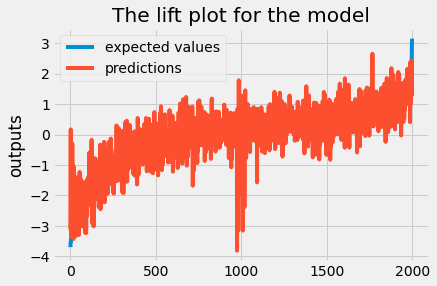

In [ ]:
lift_curve(pred_oos.flatten(), y_oos)

In [ ]:
#Except at the edges, the predictions and the actual incomes fit together with some spikes arround 1000 units